In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from astropy.io import fits
import os

import plotting
import auxil_ML as aux

In [68]:
save_plots = 1
#bins = {}
#bins_dict['AGN'] = np.linspace(-10.5, -7, 19)
#bins_dict['PSR'] = np.linspace(-10, -6.5, 19)
bins = np.linspace(-9.5, -7, 15)
binsc = (bins[1:] + bins[:-1])/2

alg0 = 'LR'

folder = '../ML_3FGL_paper/SOM'
pcat_df_dict = {}
cats = ['3FGL', '4FGL']
pops = ['AGN', 'PSR']
for cat in cats:
    cat_fn = '%s/%s_prob_catalog.csv' % (folder, cat)
    pcat_df_dict[cat] = pd.read_csv(cat_fn, index_col=0)
#print(pcat_df_dict['4FGL'].columns)

In [69]:
masks = {}
for cat in cats:
    masks[cat] = {}
    pcat_df = pcat_df_dict[cat]
    masks[cat]['AGN'] = (pcat_df['Category_%s' % cat] == 'AGN')
    masks[cat]['PSR'] = (pcat_df['Category_%s' % cat] == 'PSR')
    masks[cat]['OTHER'] = (pcat_df['Category_%s' % cat] == 'OTHER')
    masks[cat]['ASSOC'] = (pcat_df['Category_%s' % cat] != 'UNAS')
    masks[cat]['UNAS'] = (pcat_df['Category_%s' % cat] == 'UNAS')
    
    

In [70]:
fn_cats = {}
fn_cats['3FGL'] = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
fn_cats['4FGL'] = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
fgl_dfs = {}
for cat in cats:
    hdu_cat = fits.open(fn_cats[cat])
    # transform hdu table to dataframe
    fgl_df0 = aux.hdu2df(hdu_cat[1], index_name='Source_Name') 
    # remove sources with missing values
    fgl_dfs[cat] = fgl_df0.loc[pcat_df_dict[cat].index] 

In [71]:
quantity = 'Flux1000'
hists = {}
hist_other = {}
hist_unas = {}
eps = 0.00001
for cat in cats:
    df_fgl = fgl_dfs[cat]
    pcat_df = pcat_df_dict[cat]
    df_fgl['value'] = np.log10(np.array(df_fgl[quantity]))
    hists[cat] = {}
    for key in ['AGN', 'PSR', 'ASSOC', 'UNAS', 'OTHER']:
        hists[cat][key] = np.histogram(df_fgl['value'][masks[cat][key]], bins=bins)[0]
        
    other_values = df_fgl['value'][masks[cat]['OTHER']]
    unas_values = df_fgl['value'][masks[cat]['UNAS']]
    hist_other[cat] = {}
    hist_unas[cat] = {}
    for key in ['AGN', 'PSR']:
        label = '%s_%s' % (key, alg0)
        other_probs = pcat_df[label][masks[cat]['OTHER']]
        unas_probs = pcat_df[label][masks[cat]['UNAS']]
        hist_other[cat][key] = np.histogram(other_values, bins=bins, weights=other_probs)[0]
        hist_unas[cat][key] = np.histogram(unas_values, bins=bins, weights=unas_probs)[0]
        other_SP_corr = hist_other[cat][key]/(hists[cat]['ASSOC'] + eps) * hists[cat]['UNAS']
        hist_unas[cat][key + '_corr'] = hist_unas[cat][key] - other_SP_corr
        if 0:
            print(cat, key)                        
            print(hist_other[cat][key])
            print(hists[cat]['ASSOC'])
            print(hists[cat]['UNAS'])
            print(other_SP_corr)
        

Save figure to file: plots/N_logS_diff_AGN.pdf
cp plots/N_logS_diff_AGN.pdf ../ML_3FGL_paper/plots
Save figure to file: plots/N_logS_diff_PSR.pdf
cp plots/N_logS_diff_PSR.pdf ../ML_3FGL_paper/plots


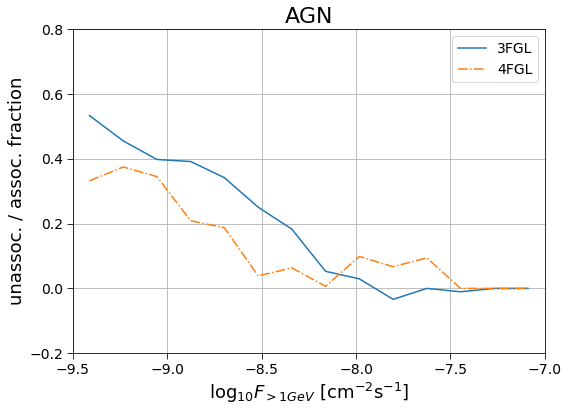

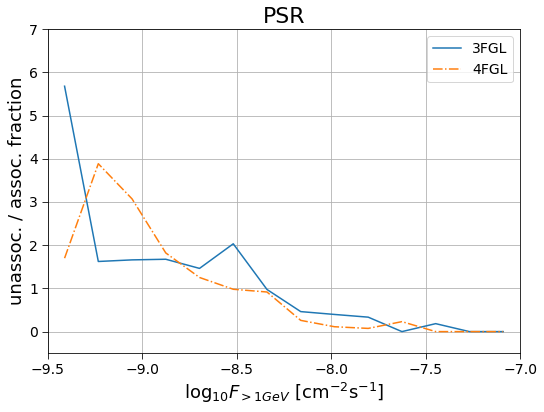

In [73]:
plotting.setup_figure_pars()
eps = 1.e-10
lss = {'3FGL':'-', '4FGL':'-.'}
for pop in pops:
    pyplot.figure()
    for cat in cats:
        ys = hist_unas[cat][pop + '_corr'] / (hists[cat][pop] + eps)
        #print(pop, cat, ys)
        pyplot.plot(binsc, ys, ls=lss[cat], label=cat)

    pyplot.legend()

    pyplot.xlabel(r'$\log_{10} F_{>1 GeV}\ [\rm cm^{-2}s^{-1}]$')
    pyplot.ylabel('unassoc. / assoc. fraction')
    pyplot.ylim(0, 10)
    pyplot.legend()
    title = pop
    pyplot.title(title)
    pyplot.xlim(bins[0], bins[-1])
    if pop == 'AGN':
        pyplot.ylim(-0.2, 0.8)
    else:
        pyplot.ylim(-0.5, 7)
    pyplot.grid()
    
    if save_plots:
        figfn_diff = 'plots/N_logS_diff_%s.pdf' % pop
        print('Save figure to file:', figfn_diff)
        pyplot.savefig(figfn_diff)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % figfn_diff
        print(cmd)
        os.system(cmd)


In [59]:
for cat in cats:
    print(cat)
    print(hists[cat]['UNAS'])
    print(hists[cat]['OTHER'])


3FGL
[212 166 120 100  61  53  33  13   6   4   0   1   0   0]
[ 5  8 13  9 10 10 15  8  9  6  7  1  3  1]
4FGL
[188 200 162  90  68  46  32   7   5   2   3   0   0   0]
[27 33 32 30 26 34 14 12 18  6  4  3  3  1]
